In [262]:
import scipy.io
import scipy.stats
import matplotlib.pyplot as pyplot
import numpy

%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [263]:
# This object encapsulates the information needed to update the cluster's
# mean and covariance matrix.
#
# The mean is a vector with the same dimension as the data (number of columns).
# The covariance matrix is a square matrix n x n where n is the same dimension 
# as the data (number of columns).
# There is a responsibility vector which contains the percentage of responsibility
# that this cluster has for every single point in the dataset. Responsibilities 
# are posteriors
# Finally, the mixing_weight is updated on every iteration. It is the prior
class Cluster(object):
    
    def __init__(self, D_dimensions, N_points):
        self.mean_vector = numpy.zeros(shape=[D_dimensions])
        self.cov_matrix = numpy.zeros(shape=[D_dimensions, D_dimensions])
        self.responsibility_vector = numpy.zeros(shape=[N_points])
        self.mixing_weight = 0



In [264]:
# Expectation Maximization Explanation
# You have two different univariate Gaussian distributions with different means and unit variance.
# You have a bunch of data points, but you're not sure which points came from which distribution, 
# and you're also not sure about the means of the two distributions.
# And now you're stuck:
# - If you knew the true means, you could figure out which data points came from which Gaussian. 
#   For example, if a data point had a very high value, it probably came from the distribution with 
#   the higher mean. But you don't know what the means are, so this won't work.
# - If you knew which distribution each point came from, then you could estimate the two distributions' means 
#   using the sample means of the relevant points. But you don't actually know which points to assign to
#   which distribution, so this won't work either.
# So neither approach seems like it works: you'd need to know the answer before you can find the answer, 
# and you're stuck.
# What EM lets you do is alternate between these two tractable steps instead of tackling the whole process 
# at once.
# http://stats.stackexchange.com/questions/72774/numerical-example-to-understand-expectation-maximization
class ExpectationMaximization(object):
    
    
    # For this constructor we need to know how many iterations we are going to run before 
    # returning a list of cluster-objects for plotting.
    # We need the dataset to extract the points from.
    # We have a object clusters which is a list of cluster-objects. I use this list as a class
    # property so that I do not have to pass it to functions as a parameter.
    # We have D_dimensions of the data (number of columns), and N_points which is the number of
    # rows in the dataset. Finally K_clusters is the length of the clusters list.
    def __init__(self, numberOfIterations, data, D_dimensions, N_points):
        self.numberOfIterations = numberOfIterations
        self.data = data
        self.clusters = None
        self.D_dimensions = D_dimensions
        self.N_points = N_points
        self.K_clusters = 0
        return
    
    
    # This function takes a list of clusters and updates every cluster one at a time.
    def Update_Clusters(self, clusters):
        self.clusters = clusters
        self.K_clusters = len(clusters)
        for iteration in range(self.numberOfIterations):
            for k_cluster in range(self.K_clusters):
                cluster = clusters[k_cluster]
                cluster = self.Update_Cluster(cluster)
        return clusters
    
    
    # This function updates one cluster at a time by:
    # First, updating the responsibilities vector. (posteriors)
    # Second, updating the mixing weight. (prior)
    # Third, updating the covariance matrix.
    # Fourth, updating the mean vector.
    def Update_Cluster(self, cluster):
        cluster.responsibility_vector = self.Update_Responsibility(cluster)
        responsibility_sum = self.Calculate_Responsibility_Sum(cluster)
        cluster.mixing_weight = self.Update_Mixing_Weight(responsibility_sum)
        cluster.cov_matrix = self.Update_Covariance(responsibility_sum, cluster)
        cluster.mean_vector = self.Update_Mean(responsibility_sum, cluster)   
        return cluster
    
    
    # The function updating responsibilities passes every single point of the dataset into a gaussian 
    # pdf to know the amount of responsibility that the current cluster holds for every
    # single point. to normalize that probability, we compute it as a bayes' rule 
    # where the responsibility is the posterior, the pdf output is the likelihood, 
    # the mixing weight is the prior, and the evidence is calculated in a separate function
    def Update_Responsibility(self, cluster): 
        responsibility_vector = numpy.zeros(shape=[self.N_points])
        for n_point in range(self.N_points):
            point = self.data[n_point]
            total_evidence = self.Calculate_Total_Evidence(point)
            likelihood = scipy.stats.multivariate_normal.pdf(point, 
                                                             mean=cluster.mean_vector, 
                                                             cov=cluster.cov_matrix)
            prior = cluster.mixing_weight
            evidence = likelihood * prior
            posterior = evidence / total_evidence
            responsibility_vector[n_point] = posterior
        return responsibility_vector
    
    
    # This function computes the total evidence for the bayes' rule in the function 
    # update_responsibility. The total evidence is used to normalize the probability 
    # output of a posterior
    def Calculate_Total_Evidence(self, point):
        total_evidence = 0.0
        for k_cluster in range(self.K_clusters):
            current_cluster = self.clusters[k_cluster]
            current_likelihood = scipy.stats.multivariate_normal.pdf(point, 
                                                                     mean=current_cluster.mean_vector, 
                                                                     cov=current_cluster.cov_matrix)
            current_prior = current_cluster.mixing_weight
            current_evidence = current_likelihood * current_prior
            total_evidence = total_evidence + current_evidence
        return total_evidence   
       
        
    # the responsibility sum is very important because is used to update the mixing weight, the
    # means vector, and covariance matrix of the current cluster
    def Calculate_Responsibility_Sum(self, cluster):
        responsibility_sum = 0
        for n in range(self.N_points):
            responsibility_sum = responsibility_sum + cluster.responsibility_vector[n]
        return responsibility_sum
    
    
    # Updating the mixing weight is very simple. It is just the division between 
    # the responsibility sum, and the number of points. 
    def Update_Mixing_Weight(self, responsibility_sum):
        mixing_weight = responsibility_sum / self.N_points
        return mixing_weight
        
       
    # This is the equation that updates the mean vector
    # (sum from n=1 to N_points of r * x) / r_sum
    #
    # Where r = responsibility of point n, x = point n.
    # The answer will be a vector because x is a vector and the sum is adding vectors
    def Update_Mean(self, responsibility_sum, cluster):
        sum_vector = numpy.empty(shape=[self.D_dimensions])
        for n_point in range(self.N_points):
            point_vector = self.data[n_point]
            responsibility = cluster.responsibility_vector[n_point]
            multiplication = responsibility * point_vector
            sum_vector = sum_vector + multiplication
        mean_vector = sum_vector / responsibility_sum
        return mean_vector
    
    
    # This is the equation that updates the covariance matrix
    # (sum from n=1 to N_points of r * (x - mu) . (x - mu).T ) / r_sum
    #
    # Where r = responsibility of point n, x = point n, mu is the mean of the cluster
    # the answer is a matrix because the dot product of (x - mu) . (x - mu).T produces a matrix
    def Update_Covariance(self, responsibility_sum, cluster):
        sum_matrix = numpy.zeros(shape=[self.D_dimensions, self.D_dimensions])
        for n_point in range(self.N_points):
            responsibility = cluster.responsibility_vector[n_point]
            point_vector = self.data[n_point]
            row_vector = numpy.atleast_2d(point_vector - cluster.mean_vector)
            column_vector = row_vector.T
            matrix = numpy.dot(column_vector, row_vector)
            mult_matrix = responsibility * matrix 
            sum_matrix = sum_matrix + mult_matrix
            
        cov_matrix = sum_matrix / responsibility_sum
        return cov_matrix
                
    

In [265]:
# This class has functions very specific to this homework
class Main(object):
    
    
    # Getting the oldFaithful dataset to test the Expectation Maximization Algorithm
    def __init__(self):
        self.EM_iterations = 5
        self.plot_iterations = 7
        self.data = scipy.io.loadmat('old_faithful.mat')['data']
        means = numpy.mean(self.data, axis=0)
        self.data = self.data - means
        self.x_values = self.data[:,0]
        self.y_values = self.data[:,1]
        self.D_dimensions = len(self.data[0,:])
        self.N_points = len(self.data[:,0])
        self.algorithm = ExpectationMaximization(self.EM_iterations, self.data, self.D_dimensions, self.N_points)
        return
    
    
    # This function starts the test of the Expectation Maximization Algorithm, and 
    # it plots the state of the two clusters every 5 iterations
    def Run(self):
        clusters = self.Init_Clusters()
        for plot_counter in range(self.plot_iterations):
            clusters = self.algorithm.Update_Clusters(clusters)
            title = 'ITERATION ' + str(plot_counter * self.EM_iterations)
            self.Plot(self.x_values, self.y_values, title, clusters[0], clusters[1])
        return
        
    
    # This function initializes the the clusters with deterministic values for easy grading
    def Init_Clusters(self):
        clusters = list()
        cluster_1 = Cluster(self.D_dimensions, self.N_points)
        cluster_1.mean_vector[0] = -1.17288986
        cluster_1.mean_vector[1] = -0.11642103
        cluster_1.cov_matrix[0,0] = 0.74072815
        cluster_1.cov_matrix[0,1] = 0.09252716
        cluster_1.cov_matrix[1,0] = 0.09252716
        cluster_1.cov_matrix[1,1] = 0.5966275
        cluster_1.mixing_weight = 0.68618439
        cluster_2 = Cluster(self.D_dimensions, self.N_points)
        cluster_2.mean_vector[0] = -0.16526981
        cluster_2.mean_vector[1] = 0.70142713
        cluster_2.cov_matrix[0,0] = 0.39312776
        cluster_2.cov_matrix[0,1] = -0.46488887
        cluster_2.cov_matrix[1,0] = -0.46488887
        cluster_2.cov_matrix[1,1] = 1.64990767
        cluster_2.mixing_weight = 0.31381561 
        clusters.append(cluster_1)
        clusters.append(cluster_2)
        return clusters
    
    
    # This function plots the data points, and the current state of the gaussian clusters.
    def Plot(self, dataXValues, dataYValues, tittle, cluster_1, cluster_2): 

            figure = pyplot.figure()
            figure.set_size_inches(20, 10, forward = True)
            subplot = figure.add_subplot(111)
            
            subplot.scatter(dataXValues, dataYValues, color='black')
            subplot.set_title(tittle, fontsize=30)
            
            points = self.Cov_Matrix_To_Points(cluster_1.cov_matrix)
            x_points = points[0] + cluster_1.mean_vector[0]
            y_points = points[1] + cluster_1.mean_vector[1]
            subplot.scatter(x_points, y_points, color='green', linewidth=4, alpha=0.5, label="Cluster 1")
            subplot.scatter(cluster_1.mean_vector[0], cluster_1.mean_vector[1], color='green', linewidth=20, alpha=1)
            
            
            points = self.Cov_Matrix_To_Points(cluster_2.cov_matrix)
            x_points = points[0] + cluster_2.mean_vector[0]
            y_points = points[1] + cluster_2.mean_vector[1]
            subplot.scatter(x_points, y_points, color='blue', linewidth=4, alpha=0.5, label="Cluster 2")
            subplot.scatter(cluster_2.mean_vector[0], cluster_2.mean_vector[1], color='blue', linewidth=20, alpha=1)

            subplot.legend(loc=2,prop={'size':25})

            pyplot.show()
            return
    
    
    # This function converts the covariance matrix to points so that we can plot the 95% confidence 
    def Cov_Matrix_To_Points(sel, cov_matrix):
        x_points = numpy.linspace(0, 2 * numpy.pi, 100) # make 100 points from 0 to 2 times pi
        sf = numpy.asarray( [ numpy.cos( x_points ), numpy.sin( x_points ) ] ) #
        [u,s,v] = numpy.linalg.svd( cov_matrix )
        pmat = u * 2.447 * numpy.sqrt(s) # 95% confidence
        output = numpy.dot(  pmat, sf )
        return output
    
    

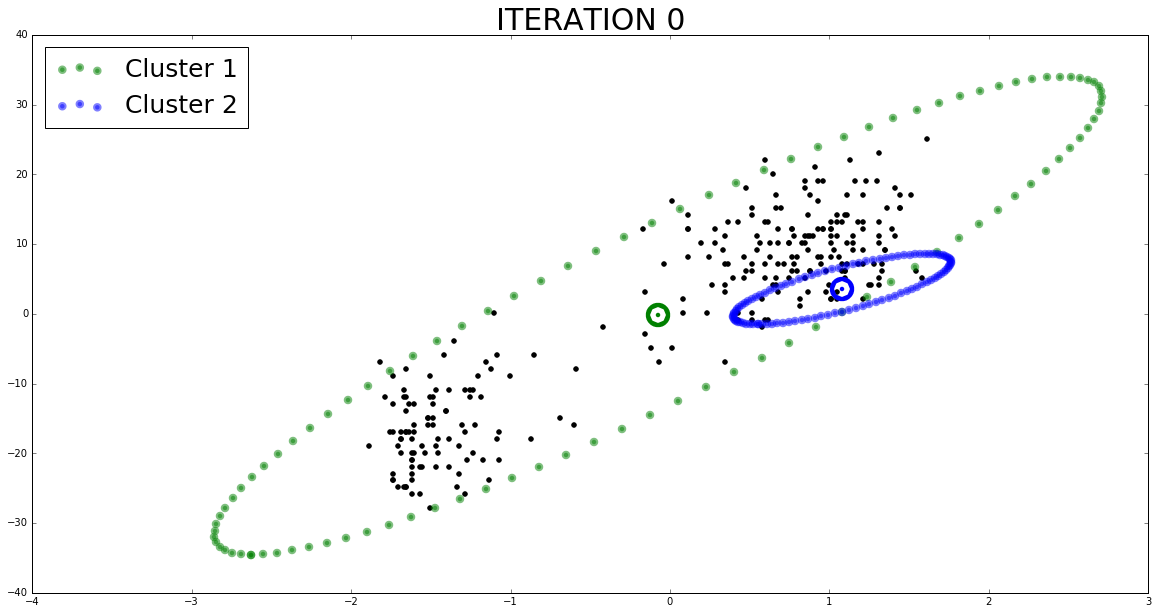

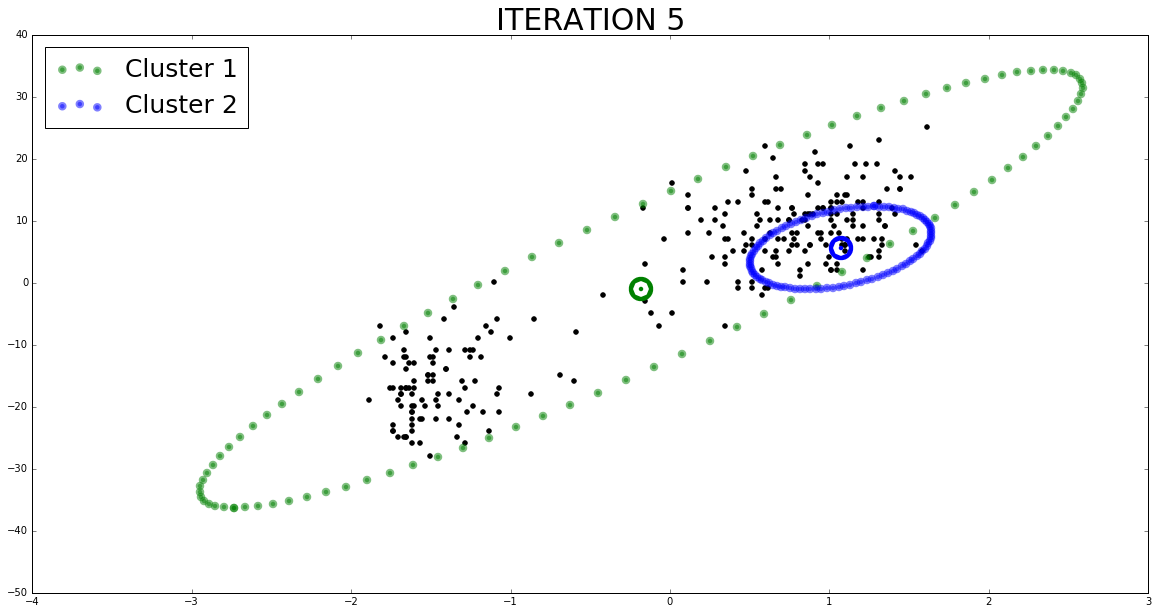

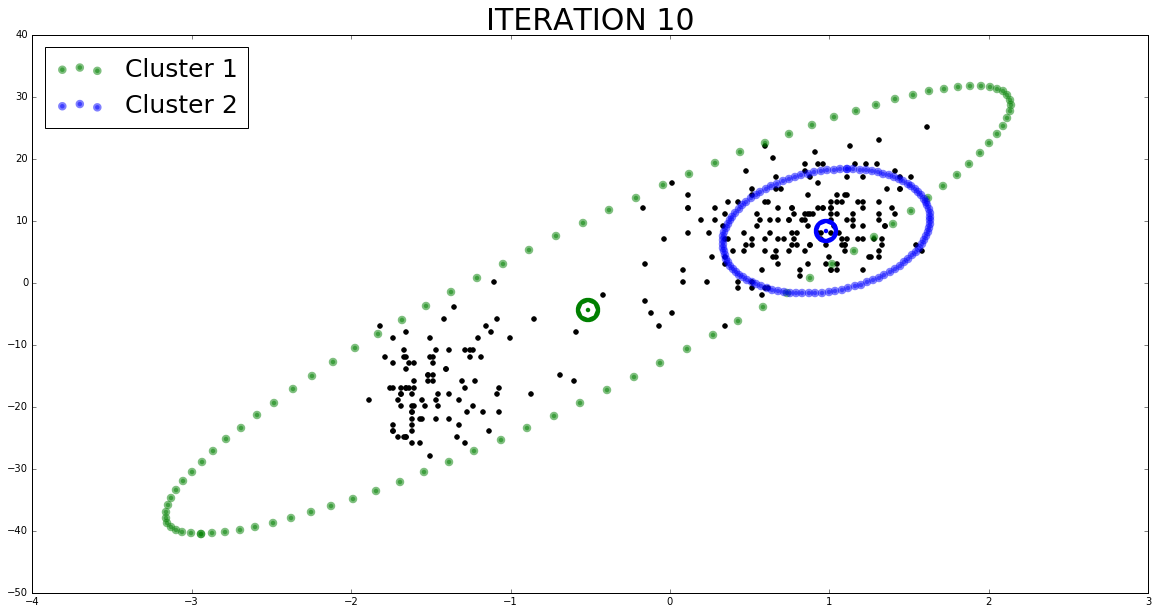

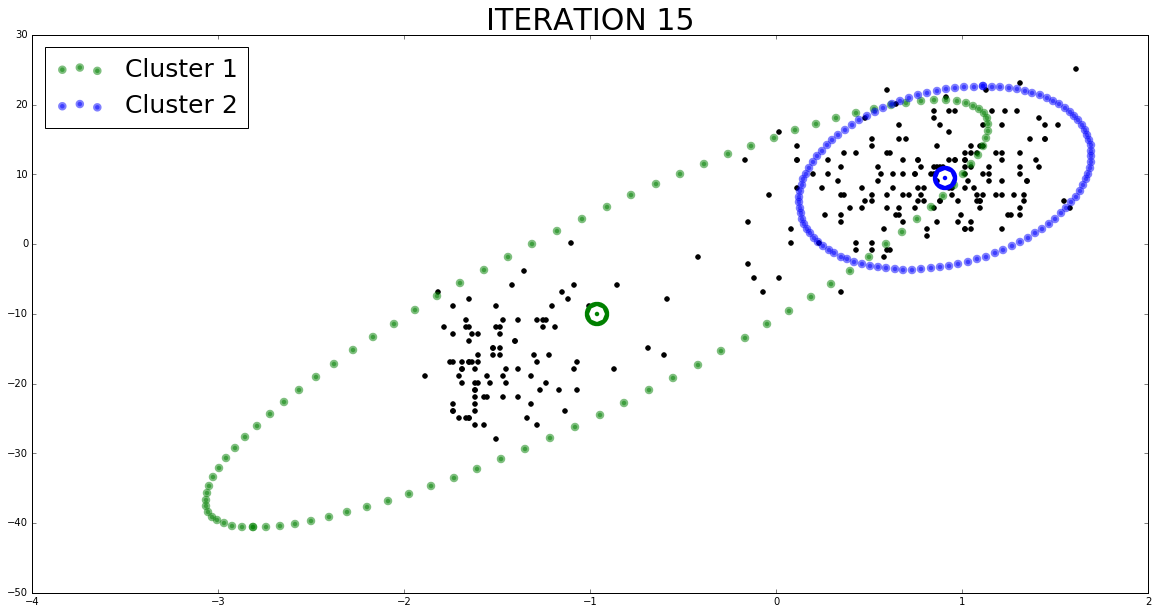

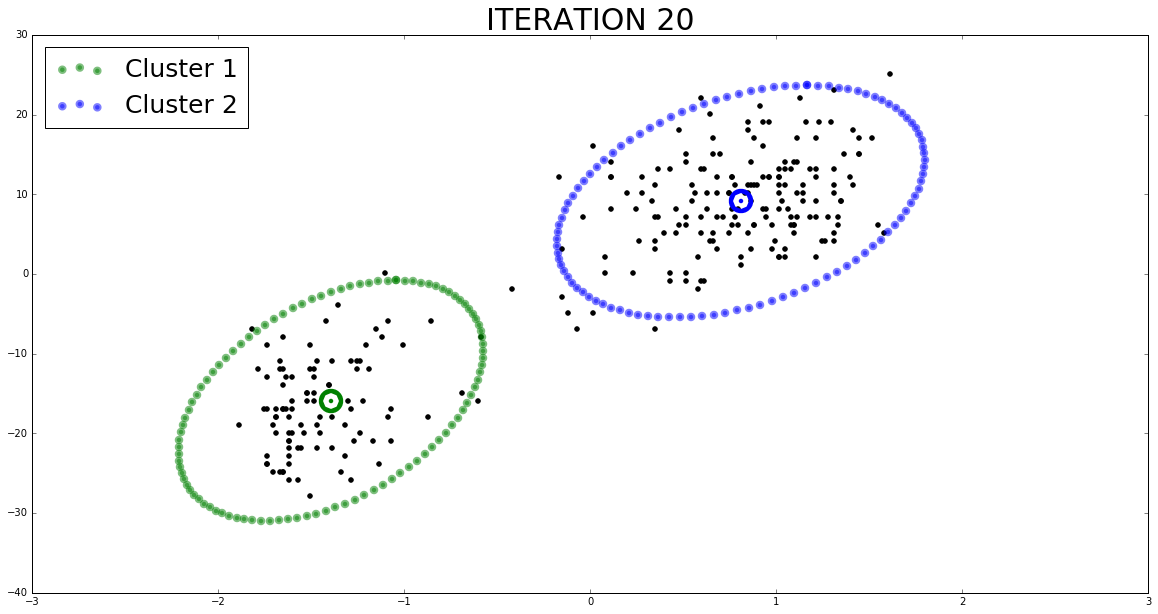

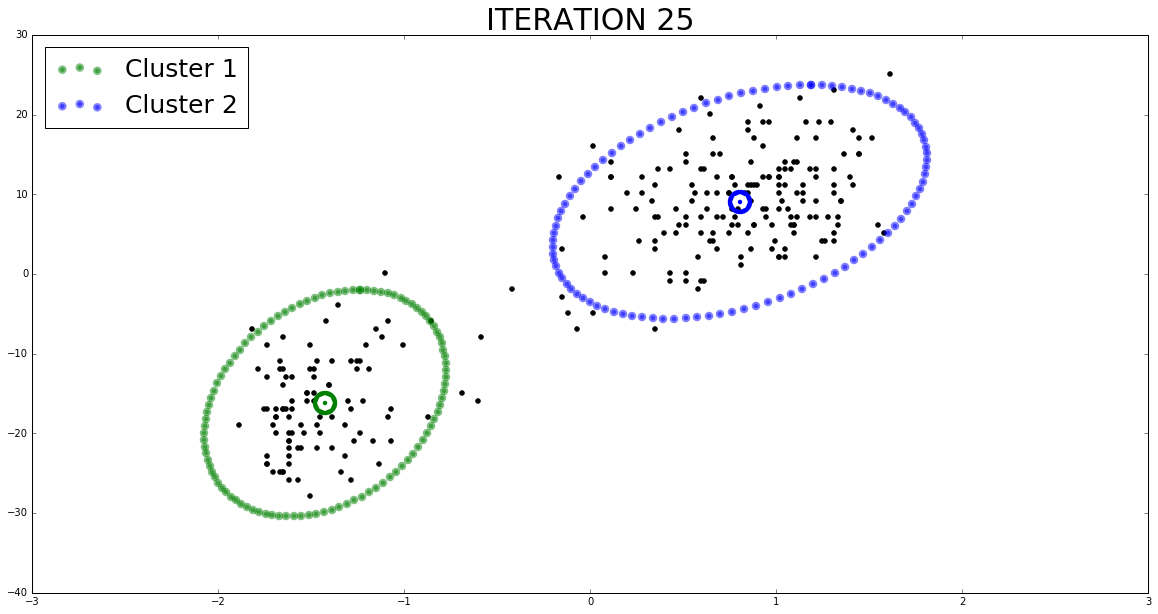

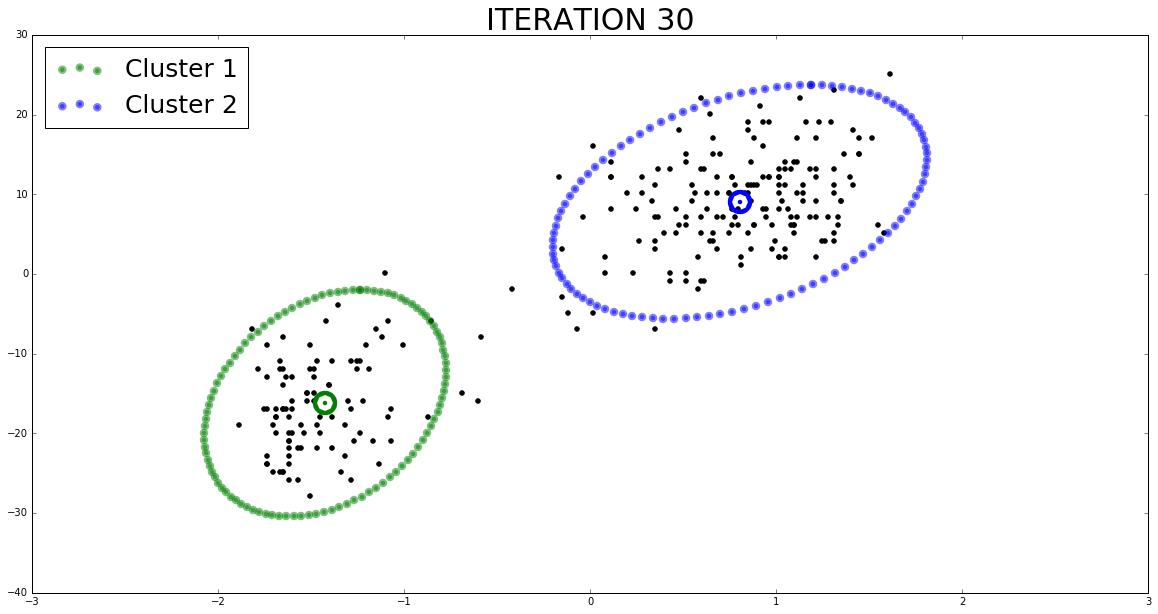

In [266]:
main = Main()
main.Run()
